# Installations that cause frequent errors on TPU

In [1]:
!pip install seaborn


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


# Set Environment

In [2]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
import matplotlib.pyplot as plt
import pandas as pd

import pickle
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LearningRateScheduler
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import gc

D0827 11:53:53.807484257    6834 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0827 11:53:53.807522914    6834 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0827 11:53:53.807527107    6834 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0827 11:53:53.807530592    6834 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0827 11:53:53.807533311    6834 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0827 11:53:53.807536169    6834 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0827 11:53:53.807539243    6834 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0827 11:53:53.

TensorFlow version: 2.12.0


# Set Seed for Reproducibility

In [3]:
def set_seed(seed=21019):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    #os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Loading data splits and one-hot encoding

In [4]:
print('Loaing data ...')
with open('/kaggle/input/data-split-additional-v2-noaug/data_splits_additional_v2_no_aug.pkl', 'rb') as f:
    loaded_splits = pickle.load(f)

x_train = loaded_splits['x_train']
x_val = loaded_splits['x_val']
x_test = loaded_splits['x_test']
y_train = loaded_splits['y_train']
y_val = loaded_splits['y_val']
y_test = loaded_splits['y_test']

y_train_encoded = to_categorical(y_train)
y_val_encoded = to_categorical(y_val)
y_test_encoded = to_categorical(y_test)

print(f'Samples in Train Set: {len(y_train_encoded)}')
print(f'Samples in Validation Set: {len(y_val_encoded)}')
print(f'Samples in Test Set: {len(y_test_encoded)}')

Loaing data ...
Samples in Train Set: 6844
Samples in Validation Set: 1712
Samples in Test Set: 2139


# Pretrained Model + New Classifier Layer

**With TPU Enabled**

In [5]:
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# instantiating the model in the strategy scope creates the model on the TPU
with tpu_strategy.scope():
    # Define class names
    class_names = list(['Type 1','Type 2','Type 3'])

    # Define the input shape
    input_shape = x_train[0].shape

    # Pretrained base
    pretrained_base = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    pretrained_base.trainable = False

    # New classification layer
    x = pretrained_base.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    outputs = Dense(len(class_names), activation='softmax')(x)

    # Create the model
    model = Model(inputs=pretrained_base.input, outputs=outputs)

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Print the summary of the model
    model.summary()

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 227, 227, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 227, 227, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 113, 113, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 113, 113, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 113, 113, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# Train Model

In [6]:
# Remove garbage to free up memory
print(f'Freeing up memory!')
gc.collect()

# Define the learning rate scheduler function
def lr_scheduler(epoch, lr):
    new_lr = lr * 0.01 if epoch % 5 == 0 else lr
    return new_lr

# Create the LearningRateScheduler callback
lr_callback = LearningRateScheduler(lr_scheduler)

# Train the model with history tapping (keeps data in a dictionary)
epochs = 25
batch_size = 16 * tpu_strategy.num_replicas_in_sync
history = model.fit(x_train, y_train_encoded, 
                    validation_data=(x_val,y_val_encoded),
                    epochs=epochs, 
                    batch_size=batch_size,
                    callbacks=[lr_callback],
                    shuffle=True)

Freeing up memory!
Epoch 1/25


2023-08-27 11:54:28.689328: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-27 11:54:28.810544: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


54/54 [==============================] - ETA: 0s - loss: 6.8793 - accuracy: 0.3403

2023-08-27 11:54:46.666128: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-27 11:54:46.774031: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


54/54 [==============================] - 33s 472ms/step - loss: 6.8793 - accuracy: 0.3403 - val_loss: 6.1201 - val_accuracy: 0.3440 - lr: 1.0000e-06
Epoch 2/25
54/54 [==============================] - 4s 74ms/step - loss: 5.3420 - accuracy: 0.3878 - val_loss: 5.4314 - val_accuracy: 0.3838 - lr: 1.0000e-06
Epoch 3/25
54/54 [==============================] - 4s 74ms/step - loss: 4.6541 - accuracy: 0.4218 - val_loss: 4.9797 - val_accuracy: 0.4065 - lr: 1.0000e-06
Epoch 4/25
54/54 [==============================] - 4s 74ms/step - loss: 4.1165 - accuracy: 0.4626 - val_loss: 4.6530 - val_accuracy: 0.4311 - lr: 1.0000e-06
Epoch 5/25
54/54 [==============================] - 4s 73ms/step - loss: 3.6629 - accuracy: 0.4934 - val_loss: 4.3533 - val_accuracy: 0.4498 - lr: 1.0000e-06
Epoch 6/25
54/54 [==============================] - 4s 73ms/step - loss: 3.4045 - accuracy: 0.5167 - val_loss: 4.3507 - val_accuracy: 0.4498 - lr: 1.0000e-08
Epoch 7/25
54/54 [==============================] - 4s 72ms/s

# Evaluate Model

In [7]:
# Remove garbage to free up memory
print(f'Freeing up memory!')
gc.collect()

loss, accuracy = model.evaluate(x_test, y_test_encoded)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

Freeing up memory!
67/67 [==============================] - 7s 20ms/step - loss: 4.1252 - accuracy: 0.4773
Test loss: 4.1252
Test accuracy: 0.4773


# Classification Report

In [8]:
# Get the true labels and predicted probabilities for the test data
# Make predictions on new images
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)

# Generate the classification report
report = classification_report(y_test, predicted_classes, target_names=class_names)
print("Classification Report:\n", report)

2023-08-27 11:56:52.315318: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-27 11:56:52.396088: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


67/67 [==============================] - 7s 20ms/step
Classification Report:
               precision    recall  f1-score   support

      Type 1       0.53      0.55      0.54       735
      Type 2       0.43      0.42      0.42       725
      Type 3       0.47      0.46      0.47       679

    accuracy                           0.48      2139
   macro avg       0.48      0.48      0.48      2139
weighted avg       0.48      0.48      0.48      2139



# Confusion Matrix

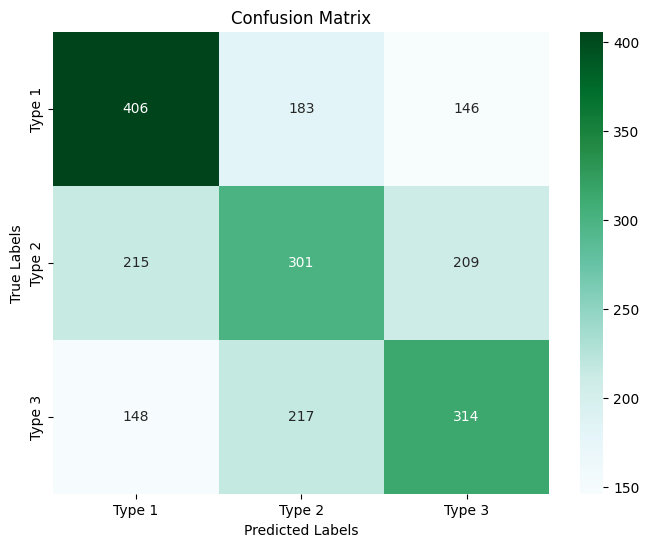

In [9]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="BuGn", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Taining Curves

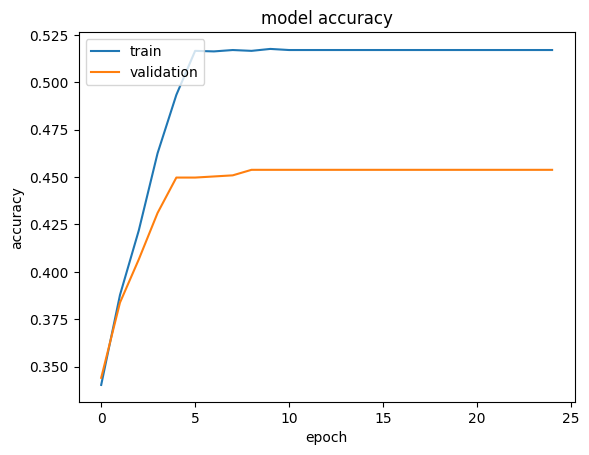

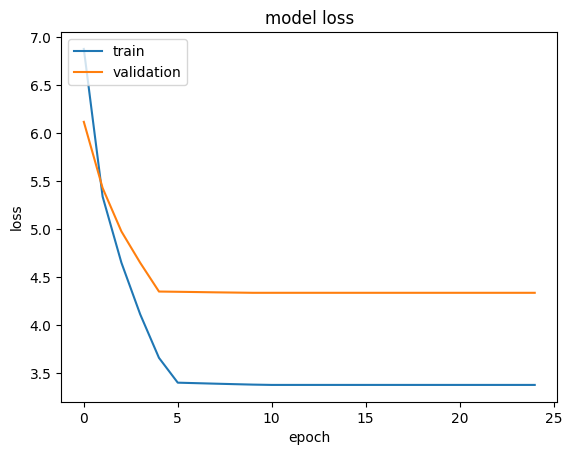

In [10]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()